In [16]:
import math
import numpy as np
import copy
import cv2
import matplotlib.pyplot as plt
import skimage as sk
import scipy.signal

from PIL import Image
from scipy import ndimage
from scipy import signal
from scipy.interpolate import interp1d
from skimage import io, morphology, filters


## Crop des images

In [17]:
def resize_image(input_image_path, output_image_path, new_width=512, new_height=486):
    try:
        original_image = Image.open(input_image_path)
        resized_image = original_image.resize((new_width, new_height), Image.ANTIALIAS)
        resized_image.save(output_image_path)
        return True
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return False

In [18]:

image = io.imread('ISIC_0000095.jpg')
resize_image('ISIC_0000095.jpg', 'ISIC_0000095_resized.jpg')


C:\Users\Nicolas\AppData\Local\Temp\ipykernel_17196\2310110843.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = original_image.resize((new_width, new_height), Image.ANTIALIAS)


True

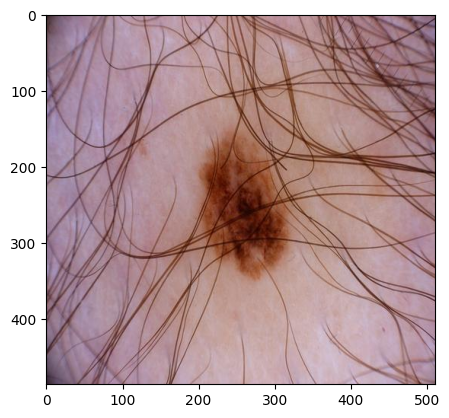

In [19]:
iamge_resized = io.imread('ISIC_0000095_resized.jpg')
plt.imshow(iamge_resized)

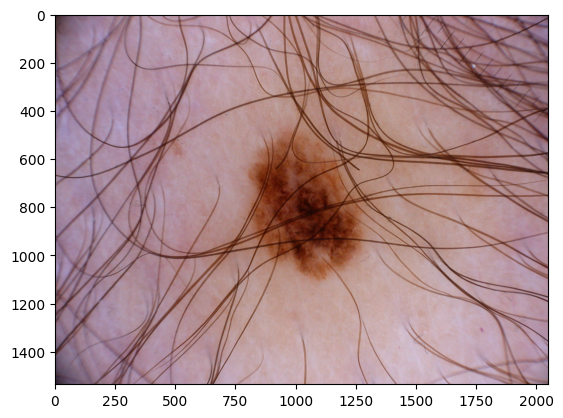

In [20]:
plt.imshow(image)

## DULLRAZOR method

In [2]:
#Définition des fonctions utilisées dans la suite:
def binary_mask_tmp(Gr,T):
    Binary_mask = np.zeros_like(Gr, dtype=np.uint8) 
    Binary_mask[Gr > T] = 1
    return Binary_mask



1. Grayscale closing operation


In [21]:
#Création des directions
S0 = np.array([[0,1,1,1,1,1,1,1,1,1,1,1,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0]])
S90 = np.transpose(S0)
S45 = np.matrix([[0,0,0,0,0,0,0,0,0],
                [0,1,0,0,0,0,0,0,0],
                [0,0,1,0,0,0,0,0,0],
                [0,0,0,1,0,0,0,0,0],
                [0,0,0,0,1,0,0,0,0],
                [0,0,0,0,0,1,0,0,0],
                [0,0,0,0,0,0,1,0,0],
                [0,0,0,0,0,0,0,1,0],
                [0,0,0,0,0,0,0,0,0]])


image = iamge_resized

red_channel = image[:, :, 0]
green_channel = image[:,:,1]
blue_channel = image[:,:,2]


def Greyscale_closing_one_channel(Color_channel):

    #Closing operations
    closing_horizontal = morphology.closing(Color_channel, S0)
    closing_diagonal = morphology.closing(Color_channel, S45)
    closing_vertical = morphology.closing(Color_channel, S90)
    #Taking the maximum
    max_closing = np.maximum(closing_horizontal, closing_diagonal, closing_vertical)
    
    return np.abs(Color_channel - max_closing)


Gr = Greyscale_closing_one_channel(red_channel)
Gv = Greyscale_closing_one_channel(green_channel)
Gb = Greyscale_closing_one_channel(blue_channel)

In [22]:
# Cleaning the mask
def cleaning_mask(Greyscale_image):
    Greyscale_image_cleaned = morphology.dilation(Greyscale_image)
    Greyscale_image_cleaned = morphology.erosion(Greyscale_image_cleaned, morphology.disk(2))
    return Greyscale_image_cleaned

Gr_cleaned = signal.medfilt(Gr,5)



2. Binary mask

In [23]:

def binary_mask(Greyscale_closed_picture,T):
    Binary_mask = np.zeros_like(Greyscale_closed_picture, dtype=np.uint8) 
    Binary_mask[Greyscale_closed_picture > T] = 1
    return Binary_mask

#Dans le papier, le seuil est de 24
Seuil = 240
Binary_mask_red = binary_mask(Gr, Seuil)  
Binary_mask_green = binary_mask(Gv,Seuil)
Binary_mask_blue = binary_mask(Gb,Seuil)


Binary_mask = np.logical_or(Binary_mask_red,Binary_mask_green,Binary_mask_blue).astype(np.uint8)


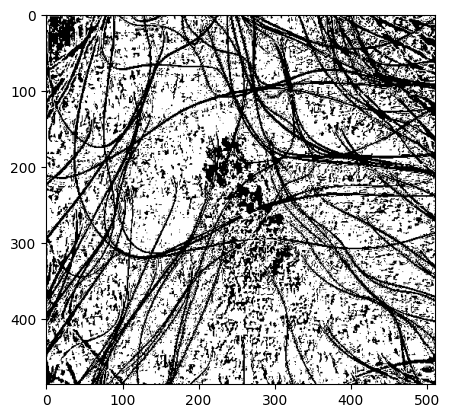

In [24]:
plt.imshow(Binary_mask,cmap='gray')

In [43]:
#checking that is is a hair pixel

#Creating the lines around the pixel
(m, n) = Binary_mask.shape[0:2]
def ligne_n(Binary_mask, i, j):
    lgth = 0
    x = i
    while x >= 0 and Binary_mask[x][j] == 0:
        lgth += 1
        x -= 1
    return lgth

def ligne_ne(Binary_mask, i, j):
    lgth = 0
    x = i
    y = j
    while x >= 0 and y < n and Binary_mask[x][y] == 0:
        lgth += 1
        y += 1
        x -= 1
    return lgth

def ligne_e(Binary_mask, i, j):
    lgth = 0
    y = j
    while y < n and Binary_mask[i][y] == 0:
        lgth += 1
        y += 1
    return lgth

def ligne_se(Binary_mask, i, j):
    lgth = 0
    x = i
    y = j
    while x < m and y < n and Binary_mask[x][y] == 0:
        lgth += 1
        y += 1
        x += 1
    return lgth

def ligne_s(Binary_mask, i, j):
    lgth = 0
    x = i
    while x < m and Binary_mask[x][j] == 0:
        lgth += 1
        x += 1
    return lgth

def ligne_so(Binary_mask, i, j):
    lgth = 0
    x = i
    y = j
    while x < m and y >= 0 and Binary_mask[x][y] == 0:
        lgth += 1
        y -= 1
        x += 1
    return lgth

def ligne_o(Binary_mask, i, j):
    lgth = 0
    y = j
    while y >= 0 and Binary_mask[i][y] == 0:
        lgth += 1
        y -= 1
    return lgth

def ligne_no(Binary_mask, i, j):
    lgth = 0
    x = i
    y = j
    while x >= 0 and y >= 0 and Binary_mask[x][y] == 0:
        lgth += 1
        y -= 1
        x -= 1
    return lgth

def ligne_sse(Binary_mask, i, j):
    lgth = 0
    x = i
    y = j
    while x < m and y < n and Binary_mask[x][y] == 0:
        lgth += 1
        x += 1
        y += 1
    return lgth

def ligne_ssw(Binary_mask, i, j):
    lgth = 0
    x = i
    y = j
    while x < m and y >= 0 and Binary_mask[x][y] == 0:
        lgth += 1
        x += 1
        y -= 1
    return lgth

def ligne_nne(Binary_mask, i, j):
    lgth = 0
    x = i
    y = j
    while x >= 0 and y < n and Binary_mask[x][y] == 0:
        lgth += 1
        x -= 1
        y += 1
    return lgth

def ligne_nnw(Binary_mask, i, j):
    lgth = 0
    x = i
    y = j
    while x >= 0 and y >= 0 and Binary_mask[x][y] == 0:
        lgth += 1
        x -= 1
        y -= 1
    return lgth

def ligne_ene(Binary_mask, i, j):
    lgth = 0
    x = i
    y = j
    while x >= 0 and y < n and Binary_mask[x][y] == 0:
        lgth += 1
        x -= 1
        y += 1
    return lgth

def ligne_wnw(Binary_mask, i, j):
    lgth = 0
    x = i
    y = j
    while x >= 0 and y >= 0 and Binary_mask[x][y] == 0:
        lgth += 1
        x -= 1
        y -= 1
    return lgth

def ligne_ese(Binary_mask, i, j):
    lgth = 0
    x = i
    y = j
    while x < m and y < n and Binary_mask[x][y] == 0:
        lgth += 1
        x += 1
        y += 1
    return lgth

def ligne_wsw(Binary_mask, i, j):
    lgth = 0
    x = i
    y = j
    while x < m and y >= 0 and Binary_mask[x][y] == 0:
        lgth += 1
        x += 1
        y -= 1
    return lgth

#Hair verification

def hair_pixel_verification(Binary_mask):
    
    (m, n) = Binary_mask.shape[0:2]

    for i in range(m):
        for j in range(n):
            
            if Binary_mask[i][j]==0:
                Liste_lignes = np.array([ligne_n(Binary_mask, i, j), ligne_ne(Binary_mask, i, j), ligne_e(Binary_mask, i, j), ligne_se(
                    Binary_mask, i, j), ligne_s(Binary_mask, i, j), ligne_so(Binary_mask, i, j), ligne_o(Binary_mask, i, j), ligne_no(Binary_mask, i, j)])
                max_length = np.max(Liste_lignes)

                if max_length > 50:
                    c=0
                    position_max = np.argmax(Liste_lignes)
                    for e in range(0,len(Liste_lignes)):
                        if e != position_max:
                            if Liste_lignes[e]<10:
                                c=c+1
                    #Le pixel n'est pas un poil si une des distances est plus grande
                    if c!=7:
                        Binary_mask[i][j]=1
                else:
                    Binary_mask[i][j]=1

    return Binary_mask


#----------Hyper paramètres:
#longueur max
seuil = 13
nombres_directions_peaux = 8
#Longueur max autorisée du poil dans les directions autres
taille_max_poil_autre = 8

def hair_pixel_verification_distances(Binary_mask_original):
    Binary_mask = copy.deepcopy(Binary_mask_original)
    m, n = Binary_mask.shape[0:2]
    # Create an array to store distances
    distances = np.zeros((m, n, 16), dtype=int)

    for i in range(m):
        for j in range(n):
            if Binary_mask[i][j]==0:
                # Calculate distances for all 8 directions and store them in 'distances' array
                distances[i, j, 0] = ligne_n(Binary_mask, i, j)
                distances[i, j, 1] = ligne_ne(Binary_mask, i, j)
                distances[i, j, 2] = ligne_e(Binary_mask, i, j)
                distances[i, j, 3] = ligne_se(Binary_mask, i, j)
                distances[i, j, 4] = ligne_s(Binary_mask, i, j)
                distances[i, j, 5] = ligne_so(Binary_mask, i, j)
                distances[i, j, 6] = ligne_o(Binary_mask, i, j)
                distances[i, j, 7] = ligne_no(Binary_mask, i, j)
                distances[i, j, 8] = ligne_sse(Binary_mask, i, j)
                distances[i, j, 9] = ligne_ssw(Binary_mask, i, j)
                distances[i, j, 10] = ligne_nne(Binary_mask, i, j)
                distances[i, j, 11] = ligne_nnw(Binary_mask, i, j)
                distances[i, j, 12] = ligne_ene(Binary_mask, i, j)
                distances[i, j, 13] = ligne_wnw(Binary_mask, i, j)
                distances[i, j, 14] = ligne_ese(Binary_mask, i, j)
                distances[i, j, 15] = ligne_wsw(Binary_mask, i, j)

    # Calculate maximum distances along each direction
    max_distances = np.max(distances, axis=2)
    for i in range(m):
        for j in range(n):
            if Binary_mask[i][j] == 0:
                max_length = max_distances[i, j]
                other_lengths = distances[i, j, distances[i, j] < taille_max_poil_autre]
                if max_length > seuil and len(other_lengths) >= nombres_directions_peaux :
                    Binary_mask[i][j] = 0
                else:
                    Binary_mask[i][j] = 1
    
    return Binary_mask, distances

Binary_mask_verified, distances = hair_pixel_verification_distances(Binary_mask)


In [51]:
import numpy as np

def find_nearest_non_hair_pixels(distances, x, y):
    m, n, _ = distances.shape
    nearest_non_hair_pixels = []

    # Sort distances for the specified pixel (x, y)
    sorted_indices = np.argsort(distances[x, y])

    # Initialize a counter to find the first two non-zero values
    count = 0
    idx = 0

    while count < 2 and idx < 16:
        x_offset, y_offset = 0, 0

        if sorted_indices[idx] == 0:  # North
            x_offset = -distances[x, y, sorted_indices[idx]]
        elif sorted_indices[idx] == 1:  # Northeast
            x_offset = -distances[x, y, sorted_indices[idx]]
            y_offset = distances[x, y, sorted_indices[idx]]
        # Add more conditions for the other directions

        x_coord = x + x_offset
        y_coord = y + y_offset

        if 0 <= x_coord < m and 0 <= y_coord < n:
            if Binary_mask[x_coord, y_coord] == 1:
                nearest_non_hair_pixels.append((x_coord, y_coord))
                count += 1

        idx += 1

    return nearest_non_hair_pixels


In [53]:
def hair_replacement(image,Binary_mask_verified):
    new_image = copy.deepcopy(image)
    m, n = Binary_mask_verified.shape[0:2]
    for i in range(m):
        for j in range(n):
            if Binary_mask_verified[i][j]==0:
                non_hair = find_nearest_non_hair_pixels(distances, i, j)
                first = non_hair[0]
                print(non_hair)
                new_image[i][j] = image[first[0]][first[1]]
    return new_image

In [54]:
replaced = hair_replacement(image,Binary_mask_verified)

IndexError: list index out of range

In [58]:
non_hair = find_nearest_non_hair_pixels(distances, 60, 40)
print(non_hair[0][1])

40


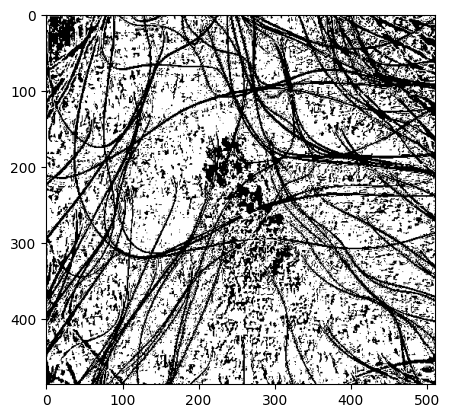

In [26]:
plt.imshow(Binary_mask,cmap='gray')

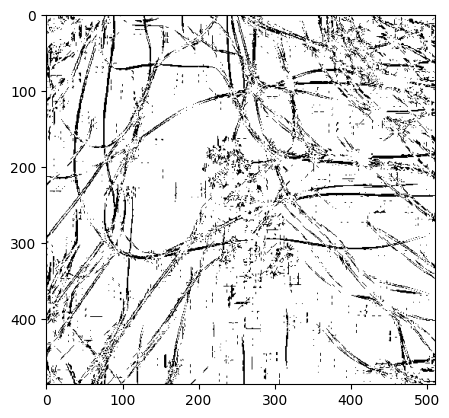

In [39]:
plt.imshow(Binary_mask_verified,cmap='gray')

3. Replacing hair-pixels by nearby non-hair pixels